## ○ Descriptive Statistics

## Step 1 — Headline length statistics

Headline Length Statistics:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


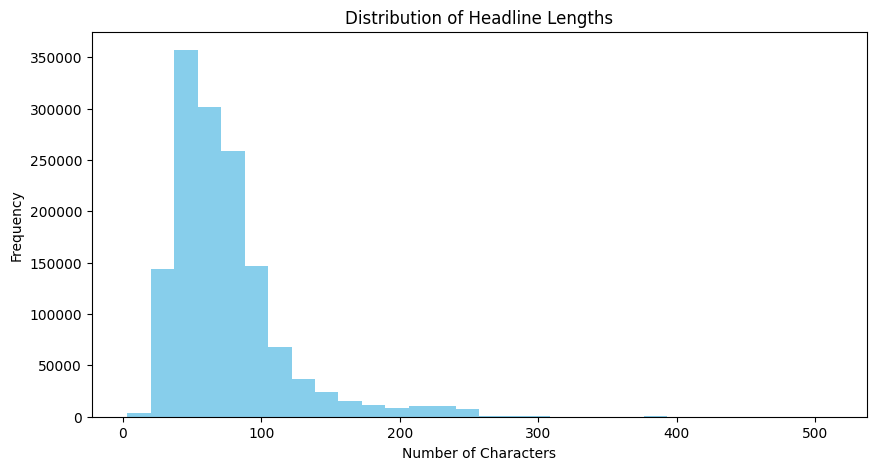

In [27]:
import pandas as pd

# Load the dataset
news_df = pd.read_csv("../data/raw_analyst_ratings.csv")

# Drop extra index column
news_df = news_df.drop(columns=['Unnamed: 0'])

# Create a new column for headline length
news_df['headline_length'] = news_df['headline'].astype(str).apply(len)

# Display basic statistics
headline_stats = news_df['headline_length'].describe()
print("Headline Length Statistics:\n", headline_stats)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(news_df['headline_length'], bins=30, color='skyblue')
plt.title("Distribution of Headline Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


## Step 2 — Articles per publisher

Top 10 Most Active Publishers:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


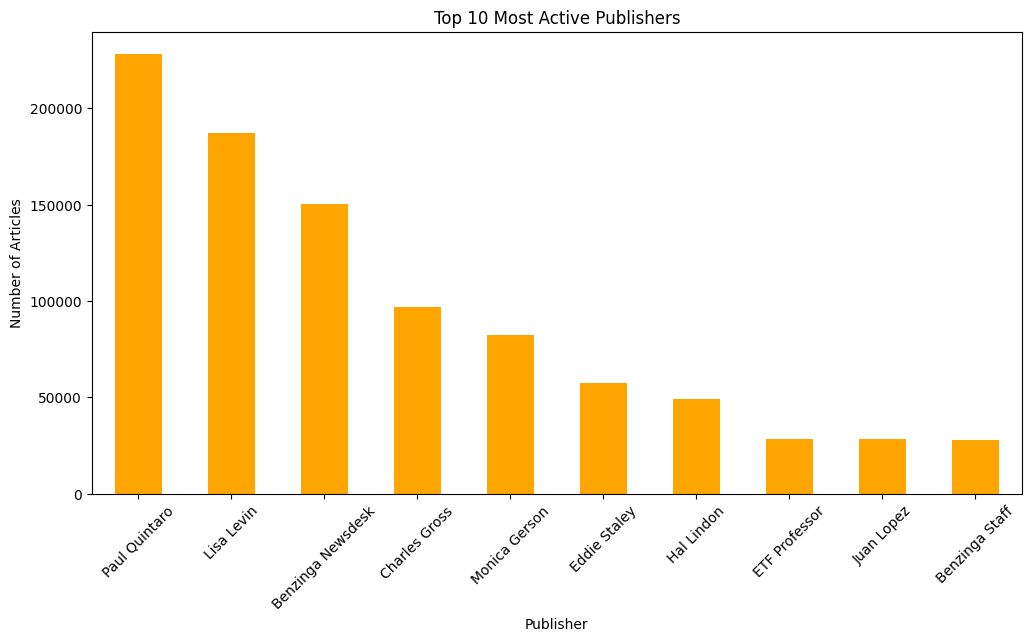

In [30]:
# Count number of articles per publisher
publisher_counts = news_df['publisher'].value_counts()

# Show the top 10 most active publishers
print("Top 10 Most Active Publishers:\n", publisher_counts.head(10))

import matplotlib.pyplot as plt

# Take top 10 most active publishers
top_publishers = publisher_counts.head(10)

# Plot
plt.figure(figsize=(12,6))
top_publishers.plot(kind='bar', color='orange')
plt.title("Top 10 Most Active Publishers")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)  # Rotate labels to fit nicely
plt.show()



## Step 3 — Analyze Publication Dates

In [32]:
# Convert 'date' column to datetime, including timezone info 
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True) 
# Check dtype print(news_df['date'].dtype)

## 1️⃣ Articles per day

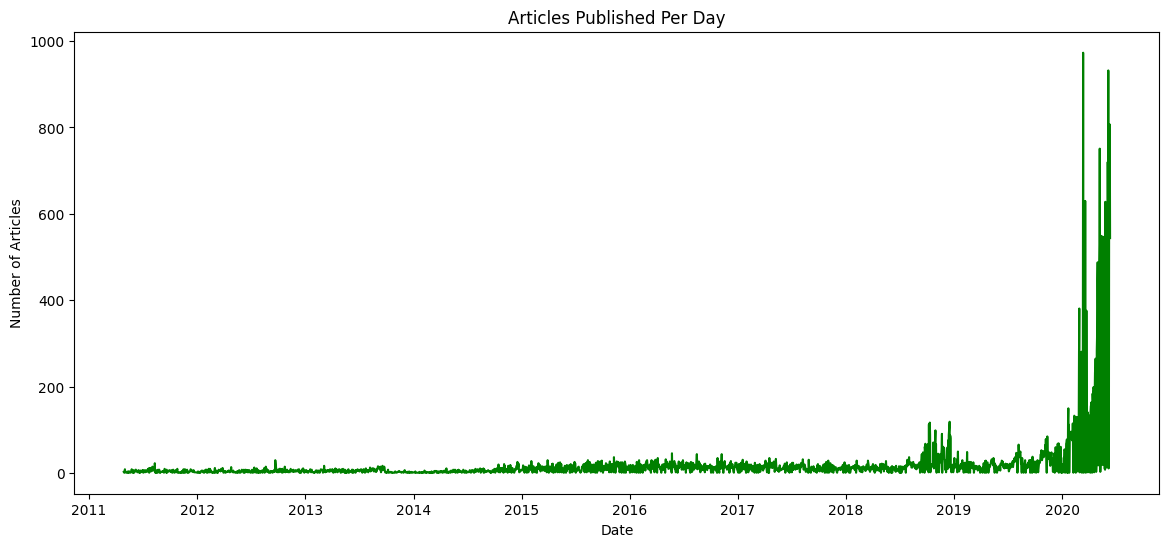

In [33]:
# Count articles per day
daily_counts = news_df.groupby(news_df['date'].dt.date).size()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
daily_counts.plot(kind='line', color='green', title="Articles Published Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()


## 2️⃣ Articles per day of the week

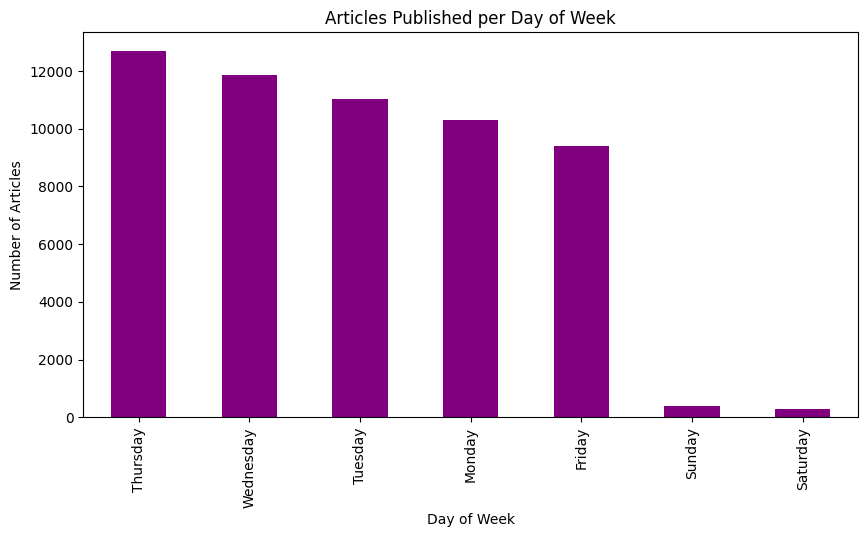

In [34]:
# Extract day of week
news_df['day_of_week'] = news_df['date'].dt.day_name()

# Count articles per day of week
day_counts = news_df['day_of_week'].value_counts()

# Plot
plt.figure(figsize=(10,5))
day_counts.plot(kind='bar', color='purple', title="Articles Published per Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Articles")
plt.show()
